# **Visualize EF5 outputs**



## Install Necessary Libraries
### Use the following command to install the `rasterio` library if not already installed

In [1]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.6 MB/s eta 0:00:00


## Import Required Libraries
### Import essential libraries for working with geospatial data

In [1]:
#import
import xml.etree.ElementTree as ET
import numpy as np
import os
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='rasterio')
import pandas as pd
import glob
from datetime import timedelta
import time
import sklearn
from sklearn.metrics import mean_squared_error
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, BoundaryNorm

## **1. Time Series Analysis for EF5 Outputs**

In this section, we will use the time series that we generate with EF5 and we will visualize the results



### Upload time series data

In [18]:
###Use this cell in Google Colab to upload the timeseries file created by EF5
from google.colab import files
timeseries = files.upload()

Saving ts.9000005.crest.csv to ts.9000005.crest.csv


In [7]:
###Use this cell in Google Colab to upload the observations file
from google.colab import files
observations = files.upload()

Saving 9000005_daily_Q.csv to 9000005_daily_Q.csv


In [43]:
##Define the paths where the data is located
ef5_file = './ts.9000005.crest.csv'
file_obs = './Obs_stations/9000005_daily_Q.csv'

# ##for google colab uncomment this lines
# ef5_file = '/content/ts.9000005.crest.csv'
# file_obs = '/content/9000005_daily_Q.csv'

## 1.1. Visualization of EF5 outputs 

In [ ]:
#Read the data
data_ts = pd.read_csv(ef5_file, parse_dates=['Time'], index_col='Time')
print(data_ts)
data_tsobs = pd.read_csv(file_obs, parse_dates=['date'], index_col='date')

                     Discharge(m^3 s^-1)  Observed(m^3 s^-1)  Precip(mm h^-1)  \
Time                                                                            
2018-06-10 01:00:00                27.29                 NaN              0.0   
2018-06-10 01:30:00                29.13                 NaN              0.0   
2018-06-10 02:00:00                29.70                 NaN              0.0   
2018-06-10 02:30:00                29.69                 NaN              0.0   
2018-06-10 03:00:00                29.43                 NaN              0.0   
...                                  ...                 ...              ...   
2018-06-28 21:00:00                 0.40                 NaN              0.0   
2018-06-28 21:30:00                 0.40                 NaN              0.0   
2018-06-28 22:00:00                 0.39                 NaN              0.0   
2018-06-28 22:30:00                 0.39                 NaN              0.0   
2018-06-28 23:00:00         

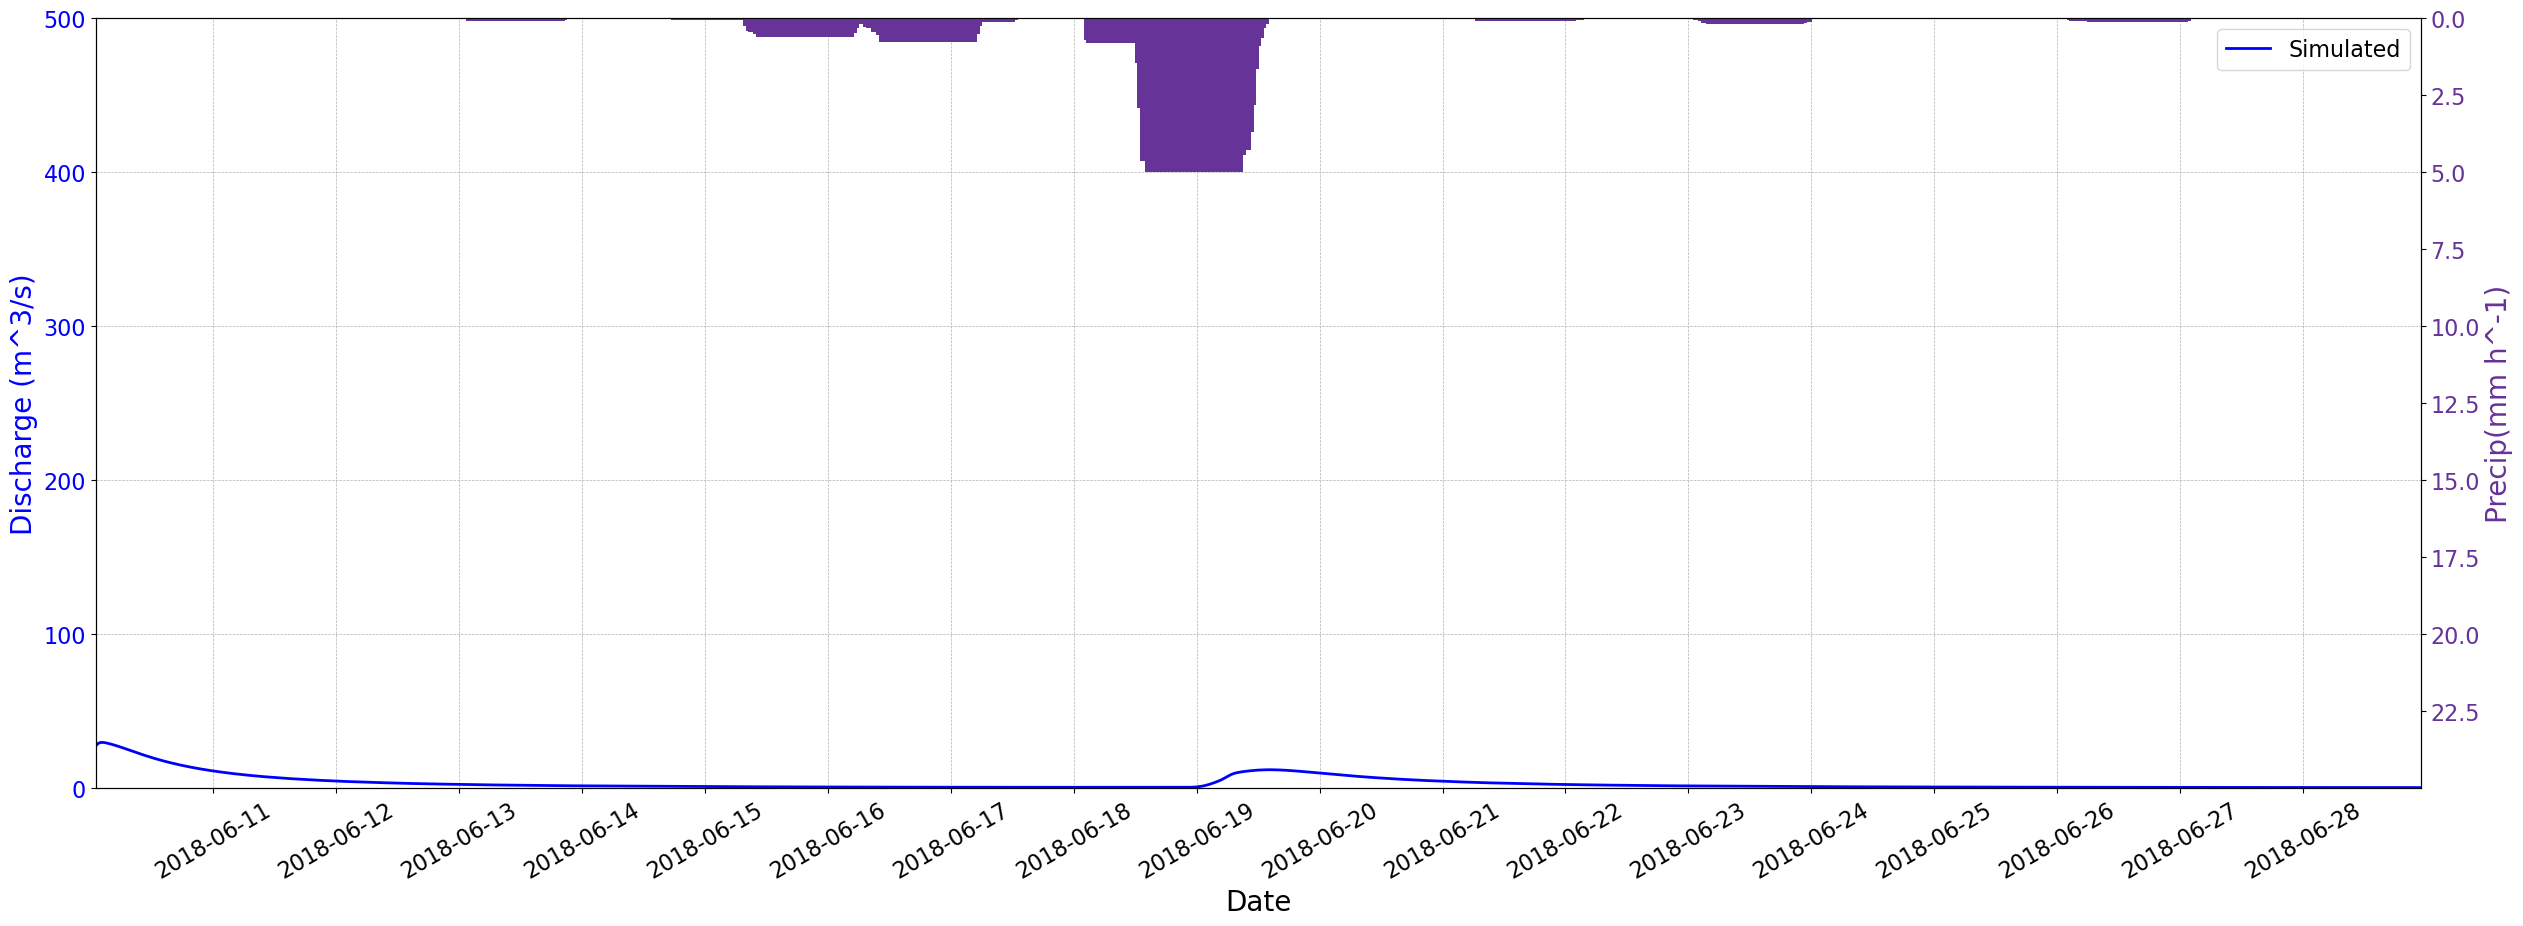

In [ ]:
## Plot the data
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,10))
ax1 = plt.subplot(1,1,1)
ax1.plot(data_ts.index, data_ts['Discharge(m^3 s^-1)'], color='blue', label='Simulated', linewidth=2)
ax1.plot(data_tsobs.index, data_tsobs['discharge'], 'x', color='black', label='Observed', markersize=10)
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Discharge (m^3/s)',fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue',labelsize=16)
ax1.set_xlim(data_ts.index.values[0], data_ts.index.values[-1])
ax1.xaxis.set_major_locator(AutoDateLocator(minticks=10, maxticks=20))
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x',labelsize=16,rotation=30)
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
ax1.set_ylim(0,500)
ax1.legend(fontsize=16)
# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(data_ts.index,data_ts['Precip(mm h^-1)'],color='rebeccapurple',alpha=1,width=0.8,align='center')
ax2.set_ylim(0,data_ts['Precip(mm h^-1)'].max()+20)
ax2.invert_yaxis()
ax2.set_ylabel('Precip(mm h^-1)', color='rebeccapurple',fontsize=20)
ax2.tick_params(axis='y', labelcolor='rebeccapurple',labelsize=16)
ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

## 1.2 Visulizing EF5 outputs against observations
In the next cells you will find some functions to visualize the generated results of the model. As you know, observations have a timestep of 1 day, so we will need to resample EF5 outputs (30 min) to daily simulations.

In [50]:
#Since we have daily observations we need to convert our EF5 outputs into the same temporal resolution.
def read_and_convert(file_ef5, file_obs):
    # Read The EF5 output
    data = pd.read_csv(file_ef5, parse_dates=['Time'], index_col='Time')

    # Filter the results between 7 am and 6 pm
    data_7am = data.between_time('07:00:00', '07:10:00')
    data_6pm = data.between_time('18:00:00', '18:10:00')

    dump_df = pd.concat([data_7am['Discharge(m^3 s^-1)'],data_6pm['Discharge(m^3 s^-1)']])
    means = dump_df.groupby(pd.Grouper(freq='1D')).mean()

    # Group by day and compute the mean
    Q_daily_df = pd.DataFrame(index=means.index)
    Q_daily_df['Discharge(m^3 s^-1)'] = means
    init = Q_daily_df.index[0]
    end = Q_daily_df.index[-1]
    init = pd.to_datetime(init)
    end = pd.to_datetime(end)


    hourly_ppt = pd.DataFrame()
    hourly_ppt['Half-hourly Precip(mm)'] = data['Precip(mm h^-1)'] / 2
    total_precip_mm_day = hourly_ppt.groupby(pd.Grouper(freq='1D')).sum()

    Q_daily_df['Precip (mm d^-1)'] = total_precip_mm_day

    Q_observed = pd.read_csv(file_obs, parse_dates=['date'], index_col='date')
    # Filter Q_observed to be between init and end dates
    Q_observed_filtered = Q_observed[(Q_observed.index >= init) & (Q_observed.index <= end)]

    return Q_daily_df, Q_observed_filtered

In [51]:
### Define Error Metrics Calculation
def calculate_error_metrics(df_simulado, df_observado):
    """
    Calculates RMSE, Bias, and NSE between simulated and observed discharge.

    Args:
        df_simulated (DataFrame): Simulated discharge data.
        df_observed (DataFrame): Observed discharge data.

    Returns:
        tuple: RMSE, Bias, and NSE values.
    """

    # Merged the two datasets so the dates coincide
    df_merged = pd.merge(df_simulado, df_observado, how='outer', left_index=True, right_index=True, suffixes=('_simulado', '_observado'))

    # Calculate the error metrics
    df_valid = df_merged.dropna(subset=['Discharge(m^3 s^-1)', 'discharge'])
    rmse = np.sqrt(mean_squared_error(df_valid['discharge'],df_valid['Discharge(m^3 s^-1)']))
    bias = (df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']).mean()
    nse = 1 - ((df_valid['Discharge(m^3 s^-1)'] - df_valid['discharge']) ** 2).sum() / ((df_valid['discharge'] - df_valid['discharge'].mean()) ** 2).sum()

    return rmse, bias, nse

In [52]:
def plotting(Q_daily_df, Q_obs, nse, bias, rmse):
    """
    Plots observed vs. simulated discharge and precipitation.

    Args:
        Q_daily_df (DataFrame): Simulated daily discharge data.
        Q_obs (DataFrame): Observed discharge data.
        nse, bias, rmse: Error metrics.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(30,10))
    ax1 = plt.subplot(1,1,1)
    ax1.plot(Q_obs.index, Q_obs['discharge'], color = 'black', label='Observed', linewidth=2)
    ax1.plot(Q_daily_df.index, Q_daily_df['Discharge(m^3 s^-1)'], color='blue', label='Simulated', linewidth=2)
    ax1.set_xlabel('Date', fontsize=20)
    ax1.set_ylabel('Discharge (m^3/s)',fontsize=20, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue',labelsize=16)
    ax1.set_xlim(Q_daily_df.index.values[0], Q_daily_df.index.values[-1])
    ax1.xaxis.set_major_locator(AutoDateLocator(minticks=10, maxticks=20))
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x',labelsize=16,rotation=30)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax1.set_ylim(0,Q_daily_df['Discharge(m^3 s^-1)'].max()+100)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.bar(Q_daily_df.index,Q_daily_df['Precip (mm d^-1)'],color='rebeccapurple',alpha=1,width=0.8,align='center')
    ax2.set_ylim(0,Q_daily_df['Precip (mm d^-1)'].max()+100)
    ax2.invert_yaxis()
    ax2.set_ylabel('Precip (mm d^-1)', color='rebeccapurple',fontsize=20)
    ax2.tick_params(axis='y', labelcolor='rebeccapurple',labelsize=16)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # add the metrics
    ax = plt.gca()
    plt.text(0.02, 0.95, f'RMSE: {rmse:.2f}\nBias: {bias:.2f}\nNSE: {nse:.2f}', transform=ax.transAxes, fontsize=16,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    ax1.legend(fontsize=16)
    #plt.title('GAUGE= 1006007')

    plt.show()


In [53]:
#Compute the daily outputs
Q_daily_ef5, Q_observed_filtered = read_and_convert(ef5_file, file_obs)
print(Q_daily_ef5)
print(Q_observed_filtered)

            Discharge(m^3 s^-1)  Precip (mm d^-1)
Time                                             
2018-06-10               20.050             0.000
2018-06-11                6.970             0.015
2018-06-12                3.285             0.005
2018-06-13                1.885             0.085
2018-06-14                1.235             0.000
2018-06-15                0.890             2.000
2018-06-16                0.685             2.085
2018-06-17                0.590             0.200
2018-06-18                0.565            11.420
2018-06-19               10.365            11.255
2018-06-20                6.600             0.060
2018-06-21                3.220             0.275
2018-06-22                1.840             0.025
2018-06-23                1.200             0.545
2018-06-24                0.865             0.040
2018-06-25                0.695             0.065
2018-06-26                0.575             0.295
2018-06-27                0.480             0.000


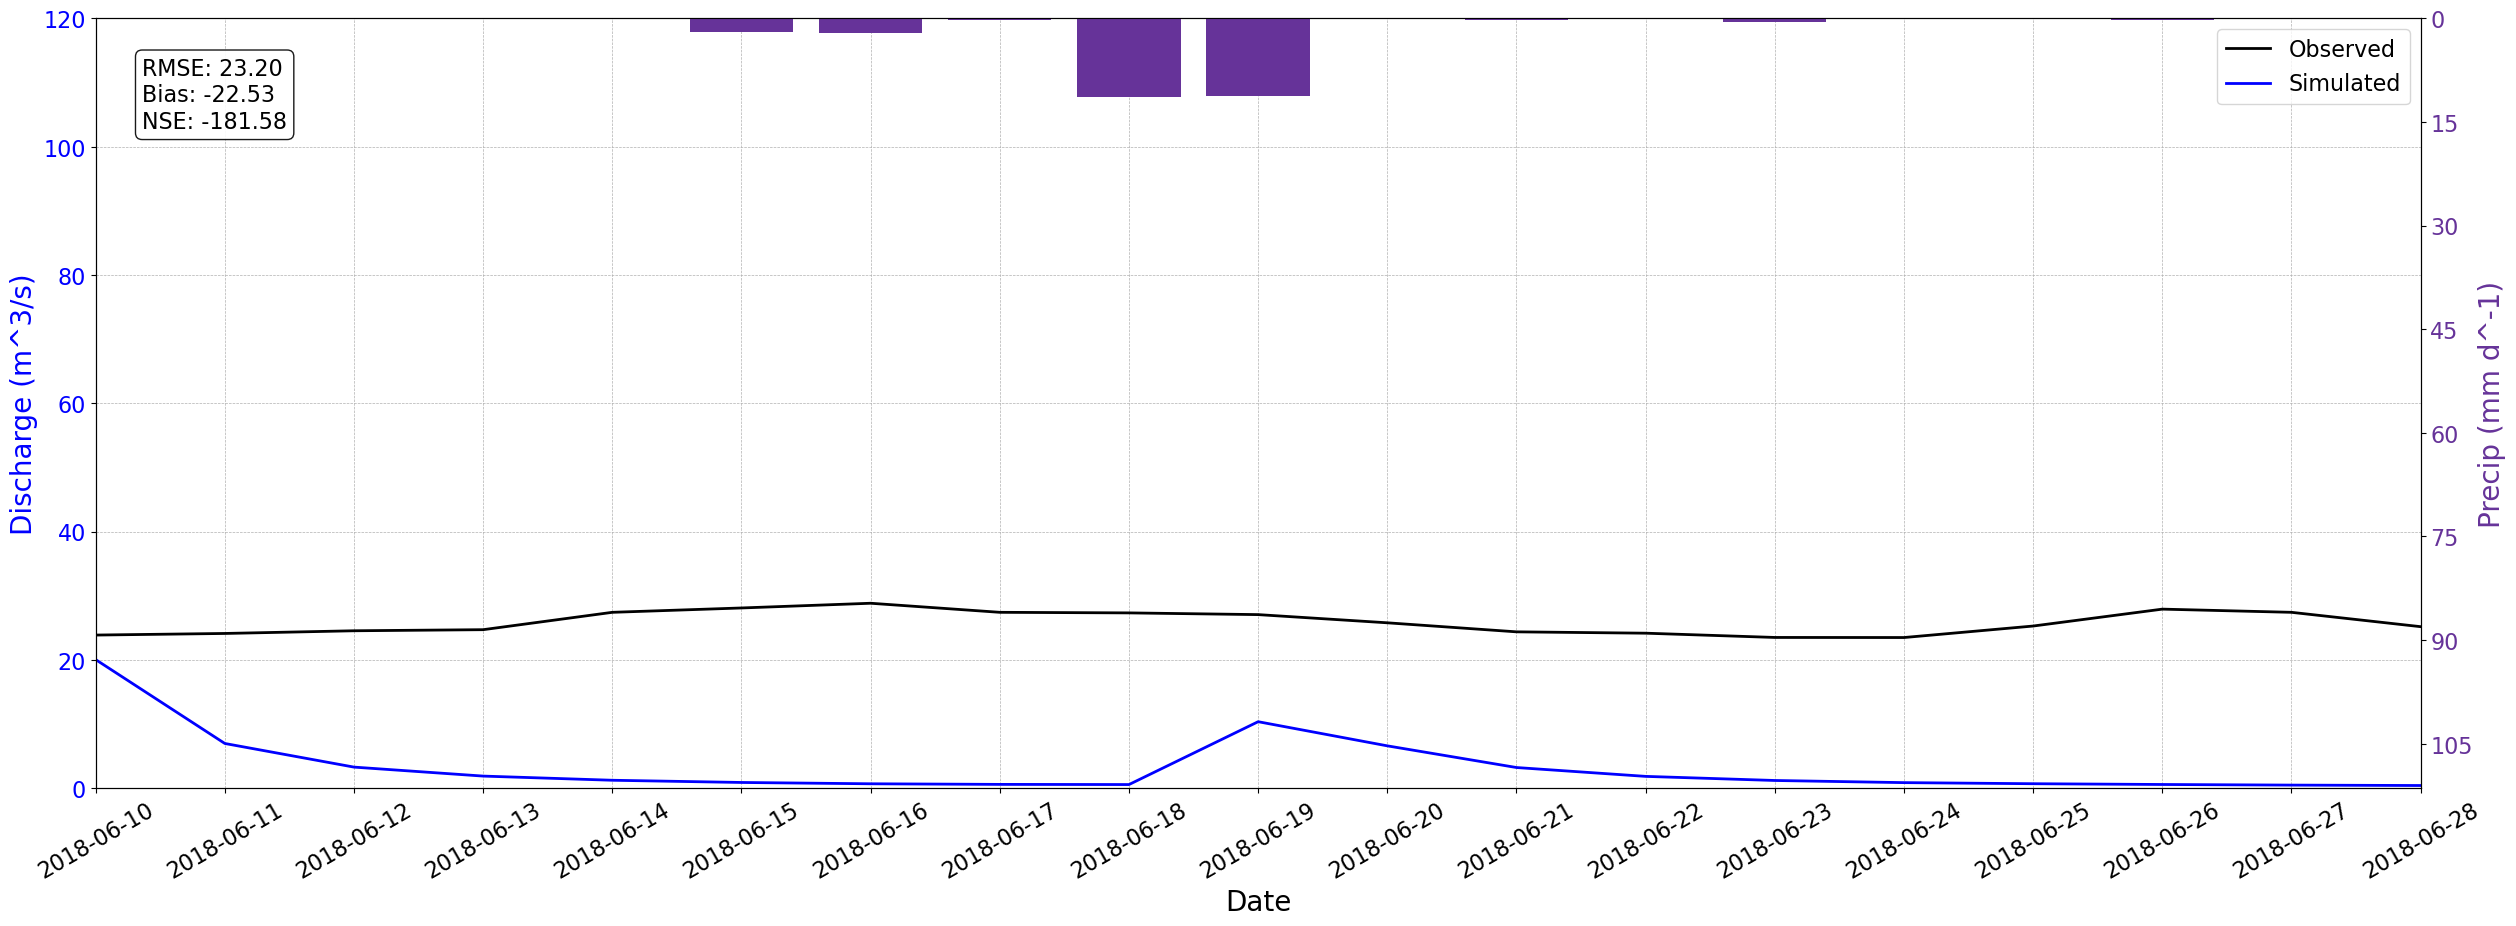

In [54]:
# Plot the results and show the error metrics (NSE, Bias, RMSE)
rmse, bias, nse = calculate_error_metrics(Q_daily_ef5['Discharge(m^3 s^-1)'], Q_observed_filtered['discharge'])
plotting(Q_daily_ef5, Q_observed_filtered, nse, bias, rmse)

## **2. Spatial Analysis of FF**
### Upload GeoTIFF files from your local machine to Google Colab

In [ ]:
#Use this cell if you are using Google Colab
from google.colab import files   ## if you are using google colab
geotiff_file = files.upload()

To verify uploaded files, use the following:

In [ ]:
os.listdir()

['control.txt',
 'Obs_stations',
 '.DS_Store',
 'Hydrosheds',
 'GIS_ghana',
 '~$Day1ppt.pptx',
 '1b_CreateBasicGrids.ipynb',
 '1_GettingBasicFiles.ipynb',
 'Day1ppt.pptx',
 'Visualize_outputs.ipynb']

For visualize the EF5 outputs in the desing colorscale we need to upload and use the color palette:

In [ ]:
#Use this cell is you are using Google Colab

#uploaded_colorramp = files.upload()

### **2.1. Define Utility Functions**

This section defines a function called *create_map_from_tif*. This function takes one argument:

**tif_file_path**: This represents the path to the GeoTIFF file that you want to visualize.
The purpose of the function is to open the GeoTIFF, read its data, and then create a visual representation of it as a map.

In [ ]:
def parse_qml_colormap(qml_file_path):
    """
    Parses the .qml file to extract colormap information from the specific structure in QGIS QML files.

    Args:
        qml_file_path: The path to the .qml file.

    Returns:
        A list of color tuples (R, G, B).
    """
    try:
        tree = ET.parse(qml_file_path)
        root = tree.getroot()

        colors = []
        # Loop through each <item> inside <colorrampshader>
        for item in root.iter('item'):
            color = item.attrib.get('color')
            if color:
                # Convert the hex color (e.g., "#595a5a") to RGB format
                try:
                    # Remove the '#' and extract the R, G, B components
                    r = int(color[1:3], 16) / 255  # Normalize to [0, 1]
                    g = int(color[3:5], 16) / 255
                    b = int(color[5:7], 16) / 255
                    colors.append((r, g, b))
                except ValueError:
                    print(f"Skipping invalid color: {color}")

        if not colors:
            print("No valid colors found in QML file.")
        return colors

    except Exception as e:
        print(f"Error parsing QML file: {e}")
        return []


### Create Map from GeoTIFF File

def create_map_from_tif(tif_file_path, qml_file_path, gauge_lat, gauge_lon):
    """
    Reads a GeoTIFF file and generates a map visualization using a custom colormap.

    Args:
        tif_file_path (str): Path to the GeoTIFF file.
        qml_file_path (str): Path to the QML colormap file.
        zoom (bool): Whether to zoom into a specific region.
    """
    try:
        # Parse the colormap from the QML file
        colormap = parse_qml_colormap(qml_file_path)

        # If no valid colors are found, raise an error
        if not colormap:
            raise ValueError("No valid colormap found in QML file.")

        # Create a custom colormap using matplotlib
        custom_cmap = ListedColormap(colormap)
        levels_map = [0, 0.5, 0.75, 1, 1.5, 1.75, 2, 2.5, 3, 4, 4.5, 5, 6, 7, 8, 10, 13, 15]
        norm = BoundaryNorm(boundaries=levels_map, ncolors=custom_cmap.N, extend='max')

        # Open the GeoTIFF file
        with rasterio.open(tif_file_path) as src:
            band1 = src.read(1)  # Read the first band

            # Replace -9999 with np.nan (for invalid or missing data)
            band1 = np.where(band1 == -9999, np.nan, band1)


            # Create latitude and longitude arrays using the extent and raster size
            extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

            limits = extent

            # The point's latitude and longitude
            point_lat = gauge_lat
            point_lon = gauge_lon

            # Display the image using imshow
            plt.figure(figsize=(13, 7))
            img = plt.imshow(
                band1,
                cmap=custom_cmap,
                norm=norm,
                extent=extent,  # Match the GeoTIFF's spatial extent
                origin="upper",  # Ensure the image is oriented correctly
            )
            plt.scatter(x=point_lon, y=point_lat, c='b', marker="*", s=40, label='Gauge')

            # Set the extent of the plot
            plt.xlim(limits[0], limits[1])
            plt.ylim(limits[2], limits[3])

            plt.title(f"Map from {tif_file_path}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")

            # Add colorbar for contour levels
            cbar = plt.colorbar(img, extend='max')
            cbar.set_label(r"Max Unit Q ($\mathrm{m^3 s^{-1} km^{-2}}$)")
            cbar.set_ticks(levels_map)
            plt.legend()

            plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {tif_file_path}")
    except rasterio.errors.RasterioIOError:
        print(f"Error: Could not read the GeoTIFF file. Check the file format or path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


### **2.3. Visualize EF5 Outputs**

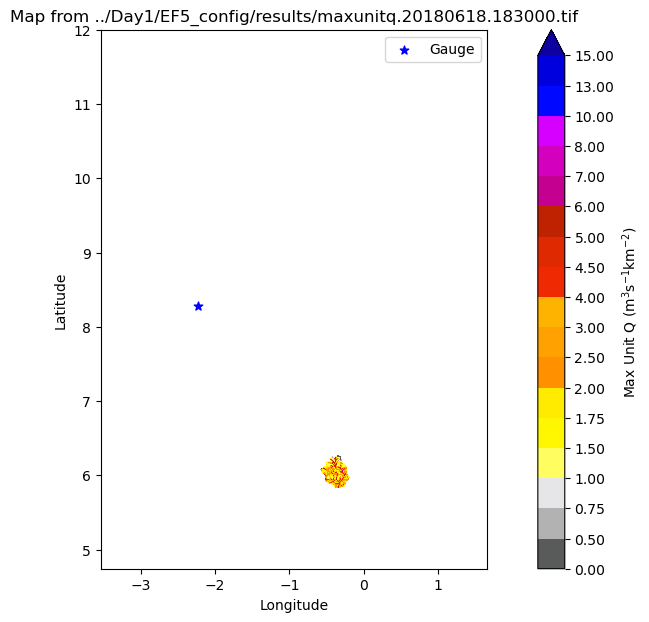

In [ ]:
# Define file paths and visualize

##Google Colab paths
# tif_file = '/content/grid_maxunitq.20180618.183000.tif'
# qml_file_path = '/content/FLASHunitQColormap_Visual.qml'

## Local machine
tif_file = '../Day1/EF5_config/results/maxunitq.20180618.183000.tif'
qml_file_path = './FLASHunitQColormap_Visual.qml'

create_map_from_tif(tif_file, qml_file_path, gauge_lat = 8.27916091, gauge_lon = -2.23761164)